In [65]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score, ConfusionMatrixDisplay  # noqa: E402
from scipy.stats import randint
#sns.set_style("darkgrid")
sns.set_style("dark")

In [66]:
def important_metrics(model, X, y):
    # Predict the labels for the given data
    y_pred = model.predict(X)

    _confusion_matrix = confusion_matrix(y, y_pred)
    # Calculate confusion matrix
    tn, fp, fn, tp = _confusion_matrix.ravel()

    # Calculate metrics
    sensitivity = recall_score(y, y_pred)
    specificity = tn / (tn + fp)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    balanced_accuracy = balanced_accuracy_score(y, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=_confusion_matrix, display_labels=model.classes_)
    disp.plot()
    plt.show()

    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Balanced Accuracy: {balanced_accuracy}")

    return None

In [67]:
def grid_search_optimization(X_training, X_test, Y_training, Y_test):
    # Model
    model = DecisionTreeClassifier(random_state=42)

    # Hiperparametry do przeszukania
    param_grid = {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': range(2,15)
    }

    # Grid Search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_training, Y_training)

    # Najlepsze parametry
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Metryki
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(Y_test, y_pred)

    tn, fp, fn, tp = cm.ravel()

    sensitivity = recall_score(Y_test, y_pred)
    specificity = tn / (tn + fp)
    precision = precision_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(Y_test, y_pred)

    metrics = {
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1,
        'balanced_accuracy': balanced_accuracy
    }

    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    cm_display.plot()
    plt.show()

    return best_params, grid_search.best_score_, metrics

In [68]:
def random_search_optimization(X_training, X_test, Y_training, Y_test):
    # Model
    model = DecisionTreeClassifier(random_state=42)

    # Hiperparametry do przeszukania
    param_dist = {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': range(2,15)
    }

    # Random Search
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)
    random_search.fit(X_training, Y_training)

    # Najlepsze parametry
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_

    # Metryki
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(Y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = recall_score(Y_test, y_pred)
    specificity = tn / (tn + fp)
    precision = precision_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(Y_test, y_pred)

    metrics = {
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1,
        'balanced_accuracy': balanced_accuracy
    }

    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    cm_display.plot()
    plt.show()

    return best_params, random_search.best_score_, metrics

# Klasyfikacja

In [69]:
dt = pl.read_excel("ftalany_klasyfikacja.xlsx")
X_training = pl.read_excel("ftalany_klasyfikacja.xlsx", sheet_name="X_train")
X_test = pl.read_excel("ftalany_klasyfikacja.xlsx", sheet_name="X_test")
Y_training = pl.read_excel("ftalany_klasyfikacja.xlsx", sheet_name="y_train")
Y_test = pl.read_excel("ftalany_klasyfikacja.xlsx", sheet_name="y_test")

Macierz korelacji pomiędzy zmiennymi niezależnymi i zmienną zależną

In [70]:
dt[:,1:6].to_pandas().corrwith(dt[:,6].to_pandas())

E HOMO     0.892842
qc-        0.891868
logSOM    -0.718056
ph         0.777599
EHOMO-1    0.638491
dtype: float64

In [71]:
X_training.to_pandas().corrwith(Y_training.to_pandas()['logk obs'])

E HOMO    -0.740826
qc-       -0.795764
logSOM     0.717356
ph        -0.792809
EHOMO-1   -0.245796
dtype: float64

In [72]:
X_test.to_pandas().corrwith(Y_test.to_pandas()['logk obs'])

E HOMO    -0.414176
qc-       -0.553332
logSOM     0.248135
ph        -0.485002
EHOMO-1   -0.156978
dtype: float64

Sprawdzenie czy zbiór testowy i treningowy są zbalansowane

In [73]:
Y_test.filter(pl.col("logk obs") == 2).shape[0] / Y_test.shape[0]

0.6666666666666666

W zbiorze testowym jest bilans 33:66

In [74]:
Y_training.filter(pl.col("logk obs") == 2).shape[0] / Y_training.shape[0]

0.5652173913043478

W zbiorze treningowym jest bilans 43:57

Idealnie bilans powinien wynosić 50:50 ale w tym przypadku uznamy to za dopuszczalne

In [75]:
dt_classifier = DecisionTreeClassifier(random_state=42)

In [76]:
dt_classifier.fit(X_training, Y_training)

DecisionTreeClassifier(random_state=42)

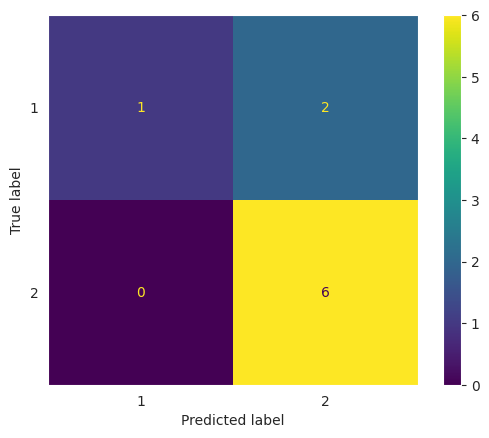

Sensitivity: 0.3333333333333333
Specificity: 0.3333333333333333
Precision: 1.0
F1 Score: 0.5
Balanced Accuracy: 0.6666666666666666


In [77]:
important_metrics(dt_classifier, X_test, Y_test)

[Text(0.4, 0.8333333333333334, 'x[3] <= -0.12\ngini = 0.491\nsamples = 23\nvalue = [10.0, 13.0]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 11\nvalue = [0, 11]'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[2] <= 0.277\ngini = 0.278\nsamples = 12\nvalue = [10, 2]'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]')]

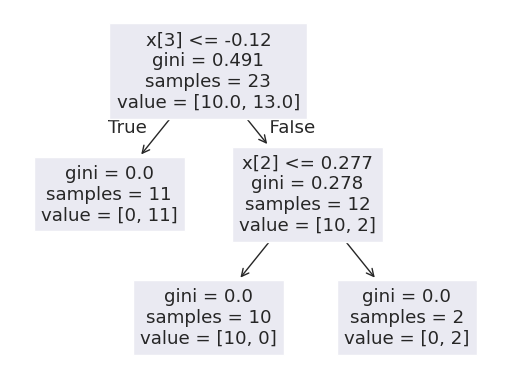

In [78]:
plot_tree(dt_classifier)

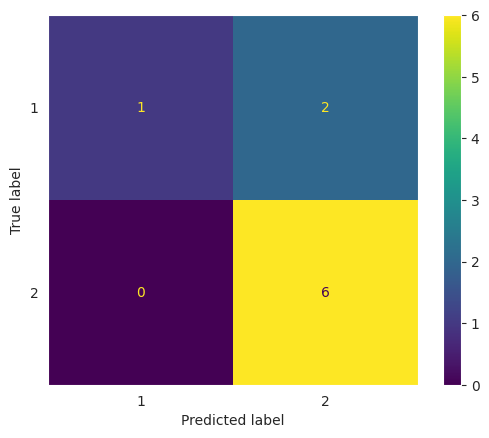

Grid Search Best Params: {'criterion': 'gini', 'max_depth': 2}
Grid Search Best Score: 0.82
Grid Search Metrics: {'sensitivity': 0.3333333333333333, 'specificity': np.float64(0.3333333333333333), 'precision': 1.0, 'f1_score': 0.5, 'balanced_accuracy': np.float64(0.6666666666666666)}


In [79]:
best_params_grid, best_score_grid, metrics_grid = grid_search_optimization(X_training, X_test, Y_training, Y_test)
print("Grid Search Best Params:", best_params_grid)
print("Grid Search Best Score:", best_score_grid)
print("Grid Search Metrics:", metrics_grid)


/home/kuba/uczenie_maszynowe/.venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 39 is smaller than n_iter=100. Running 39 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


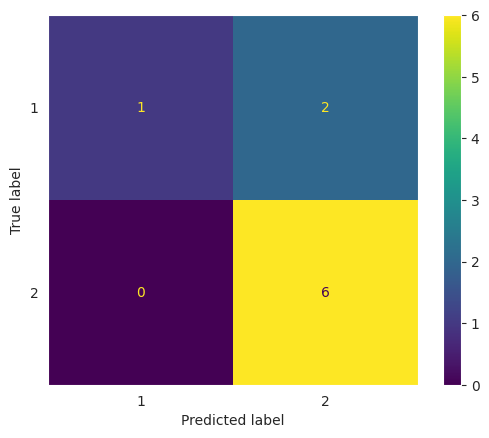

Random Search Best Params: {'max_depth': 2, 'criterion': 'gini'}
Random Search Best Score: 0.82
Random Search Metrics: {'sensitivity': 0.3333333333333333, 'specificity': np.float64(0.3333333333333333), 'precision': 1.0, 'f1_score': 0.5, 'balanced_accuracy': np.float64(0.6666666666666666)}


In [80]:
best_params_random, best_score_random, metrics_random = random_search_optimization(X_training, X_test, Y_training, Y_test)
print("Random Search Best Params:", best_params_random)
print("Random Search Best Score:", best_score_random)
print("Random Search Metrics:", metrics_random)

criterion, max depth, min_samples_split, min_samples, leaf <- 

Z optymalizacji obu sposobami wyszło, że criterion 